In [1]:
import numpy as np
import matplotlib
matplotlib.use('nbAgg')
import matplotlib.pyplot as plt
import cv2
import os
import sys
import pandas as pd
import seaborn as sns
import fastai
from fastai.vision.all import *
from fastai.vision.gan import *
from PIL import ImageDraw, ImageFont

In [2]:
DIR_DS = '../input/crop_ds/'
DIR_CROP = os.path.join(DIR_DS, 'images')
DIR_LABELS = os.path.join(DIR_DS, 'labels')

df_fns = [os.path.join(DIR_DS, fn) for fn in os.listdir(DIR_DS) if fn.endswith('.csv')]
df_fns

['../input/crop_ds/train-fold-3.csv',
 '../input/crop_ds/train-fold-4.csv',
 '../input/crop_ds/train-fold-2.csv',
 '../input/crop_ds/train-fold-0.csv',
 '../input/crop_ds/train-fold-1.csv']

In [3]:
dfs = [pd.read_csv(df_fn) for df_fn in df_fns]
df = pd.concat(dfs, axis=0, ignore_index=True)
df.head()

,id,width,height,center_x,center_y,area,fold,iou
0,0-0-0,71,65,807,435,0.0,3,0.0
1,0-1-0,56,50,875,383,0.0,3,0.0
2,0-2-0,47,43,923,266,0.0,3,0.0
3,0-3-0,27,26,1265,578,0.0,3,0.0
4,0-11-0,46,35,23,82,0.0,3,0.0


In [13]:
df.tail()

,id,width,height,center_x,center_y,area,fold,iou,hit
17342,2-5190-0,42,26,49,13,0.0,1,0.0,False
17343,2-5191-0,33,27,930,22,0.0,1,0.0,False
17344,2-5191-1,53,43,299,54,0.0,1,0.0,False
17345,2-5192-0,48,49,990,635,0.0,1,0.0,False
17346,2-5193-0,45,20,106,10,0.0,1,0.0,False


In [11]:
df.iou.hasnans

False

<IPython.core.display.Javascript object>


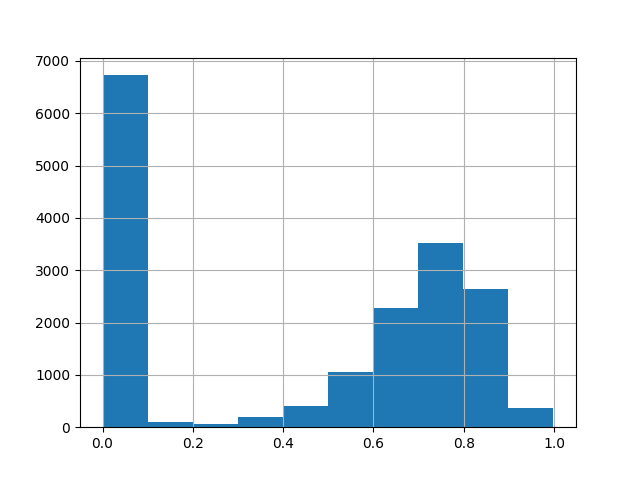

In [5]:
df.iou.hist()
plt.show()

In [14]:
df['hit'] = [th > 0.1 for th in df['iou'].values]
df['hit'].describe()

count     17347
unique        2
top        True
freq      10621
Name: hit, dtype: object

In [15]:
fold = 0
val_df = pd.read_csv(f'../input/crop_ds/train-fold-{fold}.csv')
val_df['frame_index'] = [int(s.split('-')[1]) for s in val_df['id'].values]
val_df.tail()

,id,width,height,center_x,center_y,area,fold,iou,frame_index
4016,1-11368-0,58,58,158,645,0.0,0,0.0,11368
4017,1-11369-0,58,54,159,644,0.0,0,0.0,11369
4018,1-11369-1,53,45,143,583,0.0,0,0.0,11369
4019,1-11369-2,46,55,64,583,0.0,0,0.0,11369
4020,1-11371-0,58,57,161,647,0.0,0,0.0,11371


In [16]:
val_df.frame_index.describe()

count     4021.000000
mean      7645.113653
std       3073.389497
min         24.000000
25%       8813.000000
50%       9112.000000
75%       9188.000000
max      11371.000000
Name: frame_index, dtype: float64

<IPython.core.display.Javascript object>


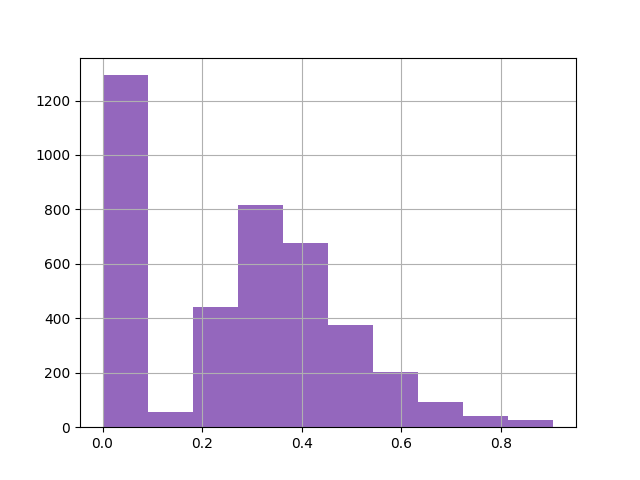

In [17]:
val_df.area.hist()
plt.show()

1016


<IPython.core.display.Javascript object>


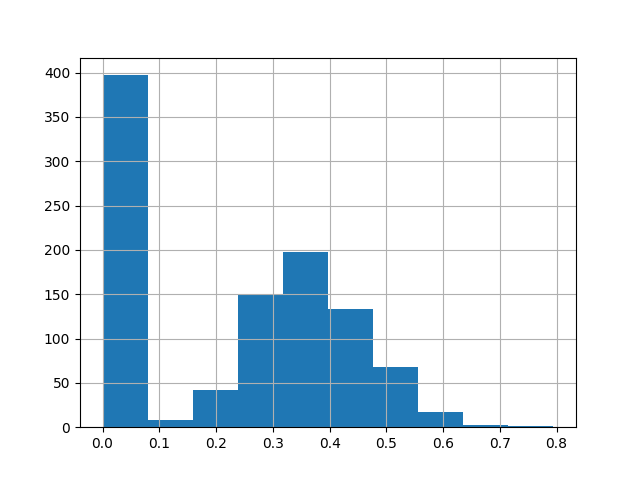

In [18]:
# keep only 25%, frame indices above 9186
val_df = val_df[val_df['frame_index'] > 9186]
print(len(val_df))
val_df.area.hist()
plt.show()

In [19]:
items = get_image_files(DIR_CROP)
mask_items = get_image_files(DIR_LABELS)

<IPython.core.display.Javascript object>


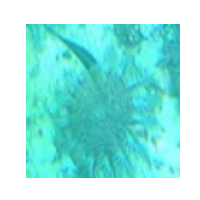

<IPython.core.display.Javascript object>


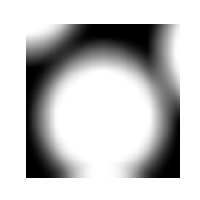

In [20]:
im1 = PILImage.create(items[0])
im2 = PILImage.create(mask_items[0])

im1.show(figsize=(2,2)); im2.show(figsize=(2,2))
plt.show()

In [21]:
def is_val(fn):
    return os.path.basename(fn).replace('.jpg','') in list(val_df['id'].values)
    
def get_dls(bs:int=32, size:int=128):
    dblock = DataBlock(
        blocks=(ImageBlock, ImageBlock),
        get_items=get_image_files,
        get_y = lambda x: os.path.join(DIR_LABELS, x.name),
        #splitter=RandomSplitter(),
        splitter=FuncSplitter(is_val),
        item_tfms=Resize(size),
        batch_tfms=[*aug_transforms(
            min_zoom=0.8,
            max_zoom=2.,
            max_lighting=0.3,
            flip_vert=True,
            
        ),
                    Normalize.from_stats(*imagenet_stats)])
    dls = dblock.dataloaders(DIR_CROP, bs=bs, path='.')
    dls.c = 3 # For 1 channel image
    return dls

dls = get_dls(bs=32)

/home/joni/miniconda3/envs/reef/lib/python3.8/site-packages/torch/_tensor.py:1051: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  /opt/conda/conda-bld/pytorch_1639180588308/work/aten/src/ATen/native/BatchLinearAlgebra.cpp:766.)
  ret = func(*args, **kwargs)


<IPython.core.display.Javascript object>


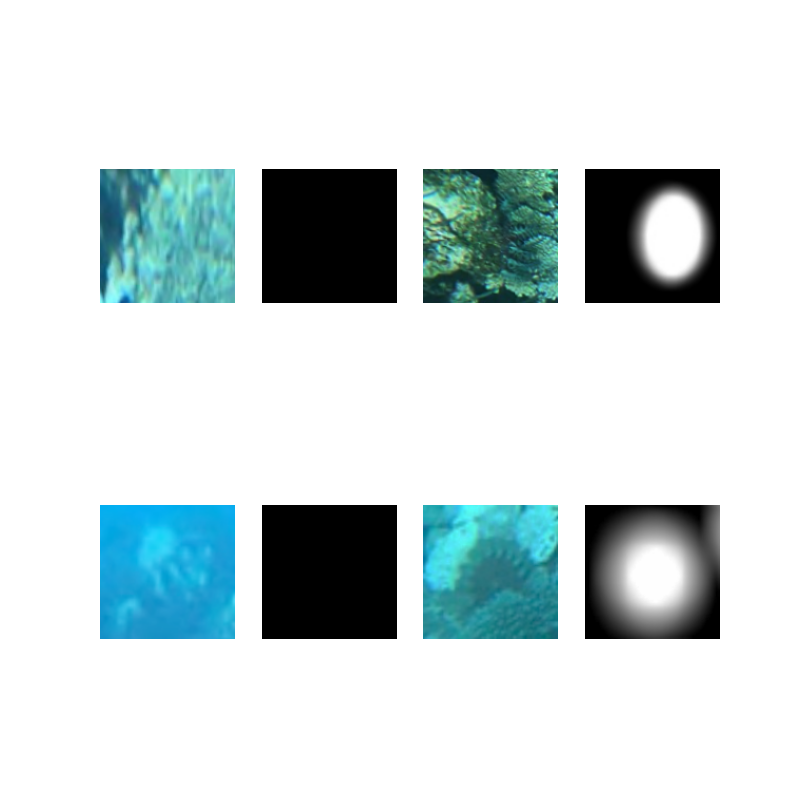

In [22]:
dls.show_batch(max_n=4, figsize=(8,8))
plt.show()

In [23]:
def create_gen_learner(dls):
    return unet_learner(
        dls, 
        arch=resnet18,#resnet34, 
        lr=0.001,
        wd=1e-3,
        loss_func = MSELossFlat(),              
        blur=True, 
        norm_type=NormType.Weight, 
        self_attention=True)

mixup = MixUp()

learn_gen = create_gen_learner(dls)

In [24]:
learn_gen.fit_one_cycle(2, pct_start=0.8, wd=1e-3, cbs=mixup)

epoch,train_loss,valid_loss,time
0,1.788542,1.350854,01:55
1,1.340880,1.052842,01:52


In [25]:
learn_gen.unfreeze()
learn_gen.fit_one_cycle(4, slice(1e-6,1e-3), wd=1e-3, cbs=mixup)

epoch,train_loss,valid_loss,time
0,1.327311,1.070070,01:56
1,1.198713,0.959658,01:56
2,1.100103,0.957589,01:56
3,1.013527,0.926324,01:56


<IPython.core.display.Javascript object>


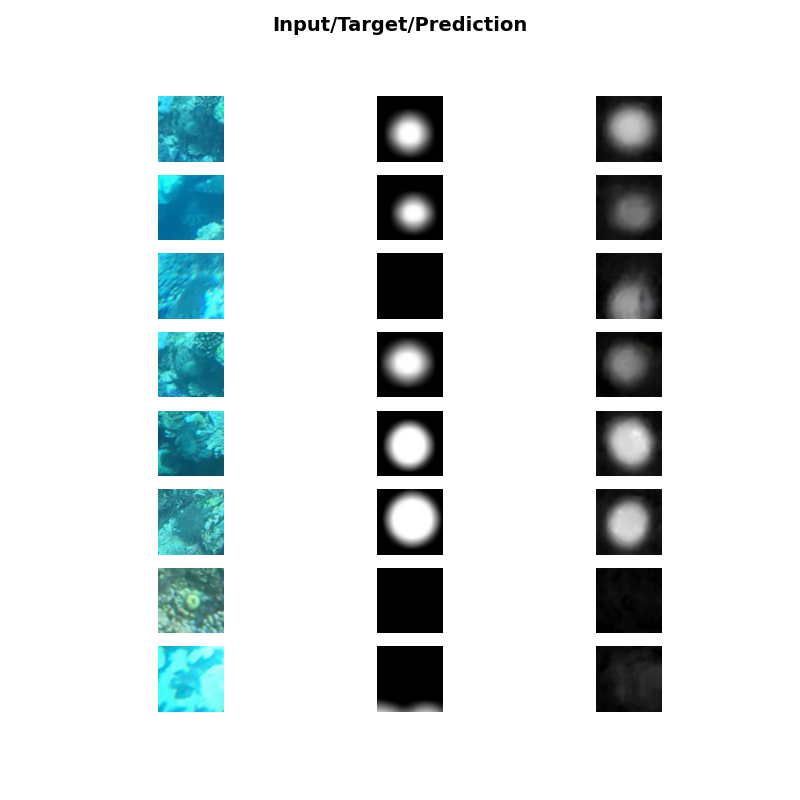

In [26]:
learn_gen.show_results(max_n=8, figsize=(8,8))
plt.show()

<IPython.core.display.Javascript object>


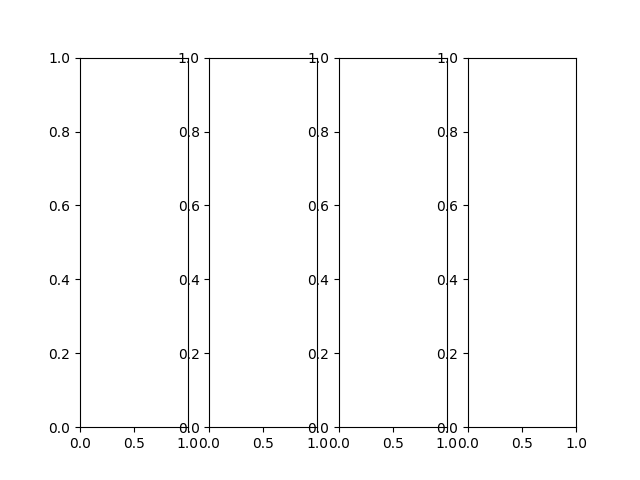

<IPython.core.display.Javascript object>


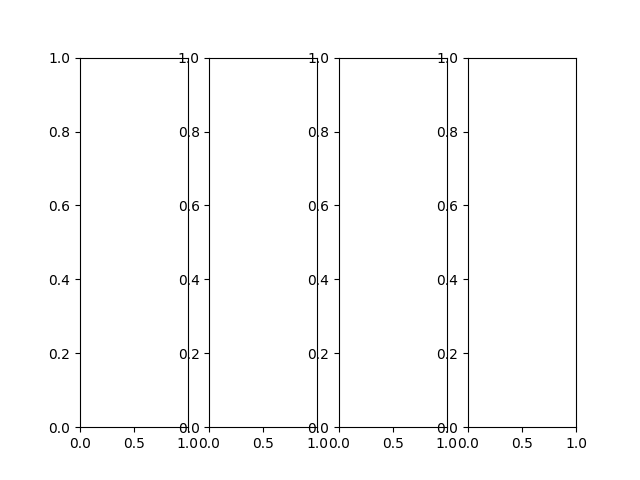

<IPython.core.display.Javascript object>


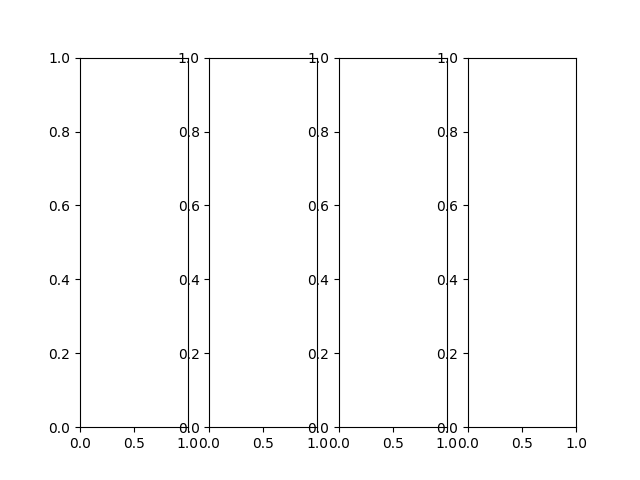

<IPython.core.display.Javascript object>


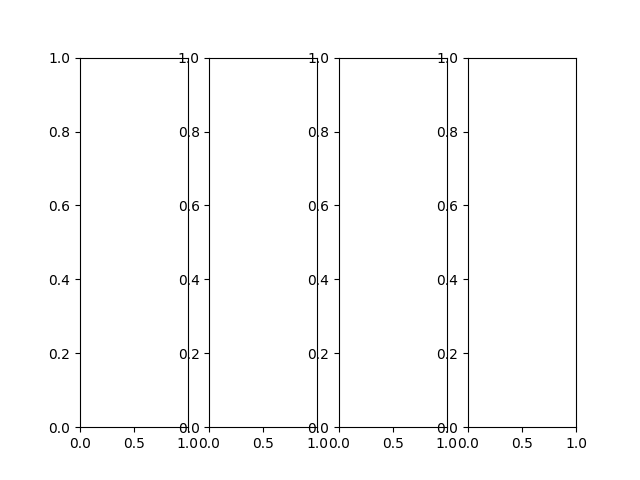

<IPython.core.display.Javascript object>


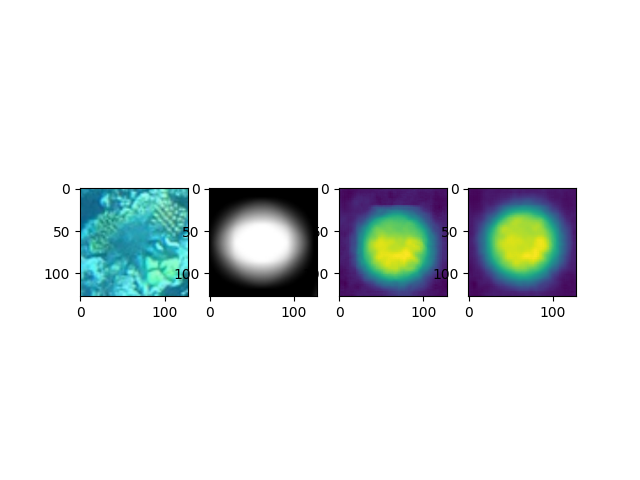

In [48]:
index = 0

f, axs = plt.subplots(1,4)
img_fn = os.path.join(DIR_CROP, val_df['id'].values[index] + '.jpg')
mask_fn = os.path.join(DIR_LABELS, val_df['id'].values[index] + '.jpg')
img = cv2.cvtColor(cv2.imread(img_fn), cv2.COLOR_BGR2RGB)
mask = cv2.imread(mask_fn)
pred = learn_gen.predict(img)

pred_tta_0 = learn_gen.predict(img)[0].detach().numpy()[0]
pred_tta_1 = learn_gen.predict(img[::-1,:,:])[0].detach().numpy()[0,::-1,:]
pred_tta_2 = learn_gen.predict(img[:,::-1,:])[0].detach().numpy()[0,:,::-1]
pred_tta_3 = learn_gen.predict(img[::-1,::-1,:])[0].detach().numpy()[0,::-1,::-1]
pred_tta = np.mean(np.stack([pred_tta_0, pred_tta_1, pred_tta_2, pred_tta_3], 0), 0)

axs[0].imshow(img)
axs[1].imshow(mask)
axs[2].imshow(pred[0].detach().numpy()[0])
axs[3].imshow(pred_tta)
plt.show()

In [37]:
torch.save(learn_gen.model.state_dict(), f'starfish_seg_resnet18_unet_{fold}.pth')

In [28]:
def extract_values(pred):
    # center crop
    margin=24
    crop = pred[margin:-margin,margin:-margin]
    mean_val = np.mean(crop)
    max_val = np.max(crop)
    center = int(crop[crop.shape[0]//2, crop.shape[1]//2])
    return mean_val, max_val, center

In [59]:
gts = []
mean_vals = []
max_vals = []
center_vals = []
for i in range(len(val_df)):
    img_fn = os.path.join(DIR_CROP, val_df['id'].values[i] + '.jpg')
    mask_fn = os.path.join(DIR_LABELS, val_df['id'].values[i] + '.jpg')
    img = cv2.cvtColor(cv2.imread(img_fn), cv2.COLOR_BGR2RGB)
    mask = cv2.imread(mask_fn)
        
    pred_tta_0 = learn_gen.predict(img)[0].detach().numpy()[0]
    #pred_tta_1 = learn_gen.predict(img[::-1,:,:])[0].detach().numpy()[0,::-1,:]
    pred_tta_2 = learn_gen.predict(img[:,::-1,:])[0].detach().numpy()[0,:,::-1]
    #pred_tta_3 = learn_gen.predict(img[::-1,::-1,:])[0].detach().numpy()[0,::-1,::-1]
    pred_tta = np.mean(np.stack([pred_tta_0, pred_tta_2], 0), 0)

    mean_val, max_val, center_val = extract_values(pred_tta)
    
    mean_vals.append(mean_val)
    max_vals.append(max_val)
    center_vals.append(center_val)

In [60]:
val_df['pred_mean'] = mean_vals
val_df['pred_max'] = max_vals
val_df['pred_center'] = center_vals
val_df['pred_feat1'] = np.array(mean_vals)/255 * np.array(max_vals)/255 * np.array(center_vals)/255
val_df['box_size'] = val_df['width'].values * val_df['width'].values
val_df['gt'] = val_df['iou'].values > 0.1

In [61]:
val_df.head()

,id,width,height,center_x,center_y,area,fold,iou,frame_index,pred_mean,pred_max,pred_center,pred_feat1,box_size,gt
3005,1-9187-0,45,42,404,386,0.328717,0,0.757854,9187,159.255156,224.5,204,0.439865,2025,True
3006,1-9187-1,42,37,337,152,0.334743,0,0.789458,9187,102.602266,156.5,151,0.146227,1764,True
3007,1-9187-2,58,59,468,427,0.425586,0,0.705897,9187,173.915859,248.5,229,0.596871,3364,True
3008,1-9187-3,69,60,148,603,0.444892,0,0.829015,9187,211.846172,255.0,245,0.798190,4761,True
3009,1-9187-4,60,54,61,633,0.242105,0,0.530864,9187,94.120469,139.5,135,0.106898,3600,True


<IPython.core.display.Javascript object>


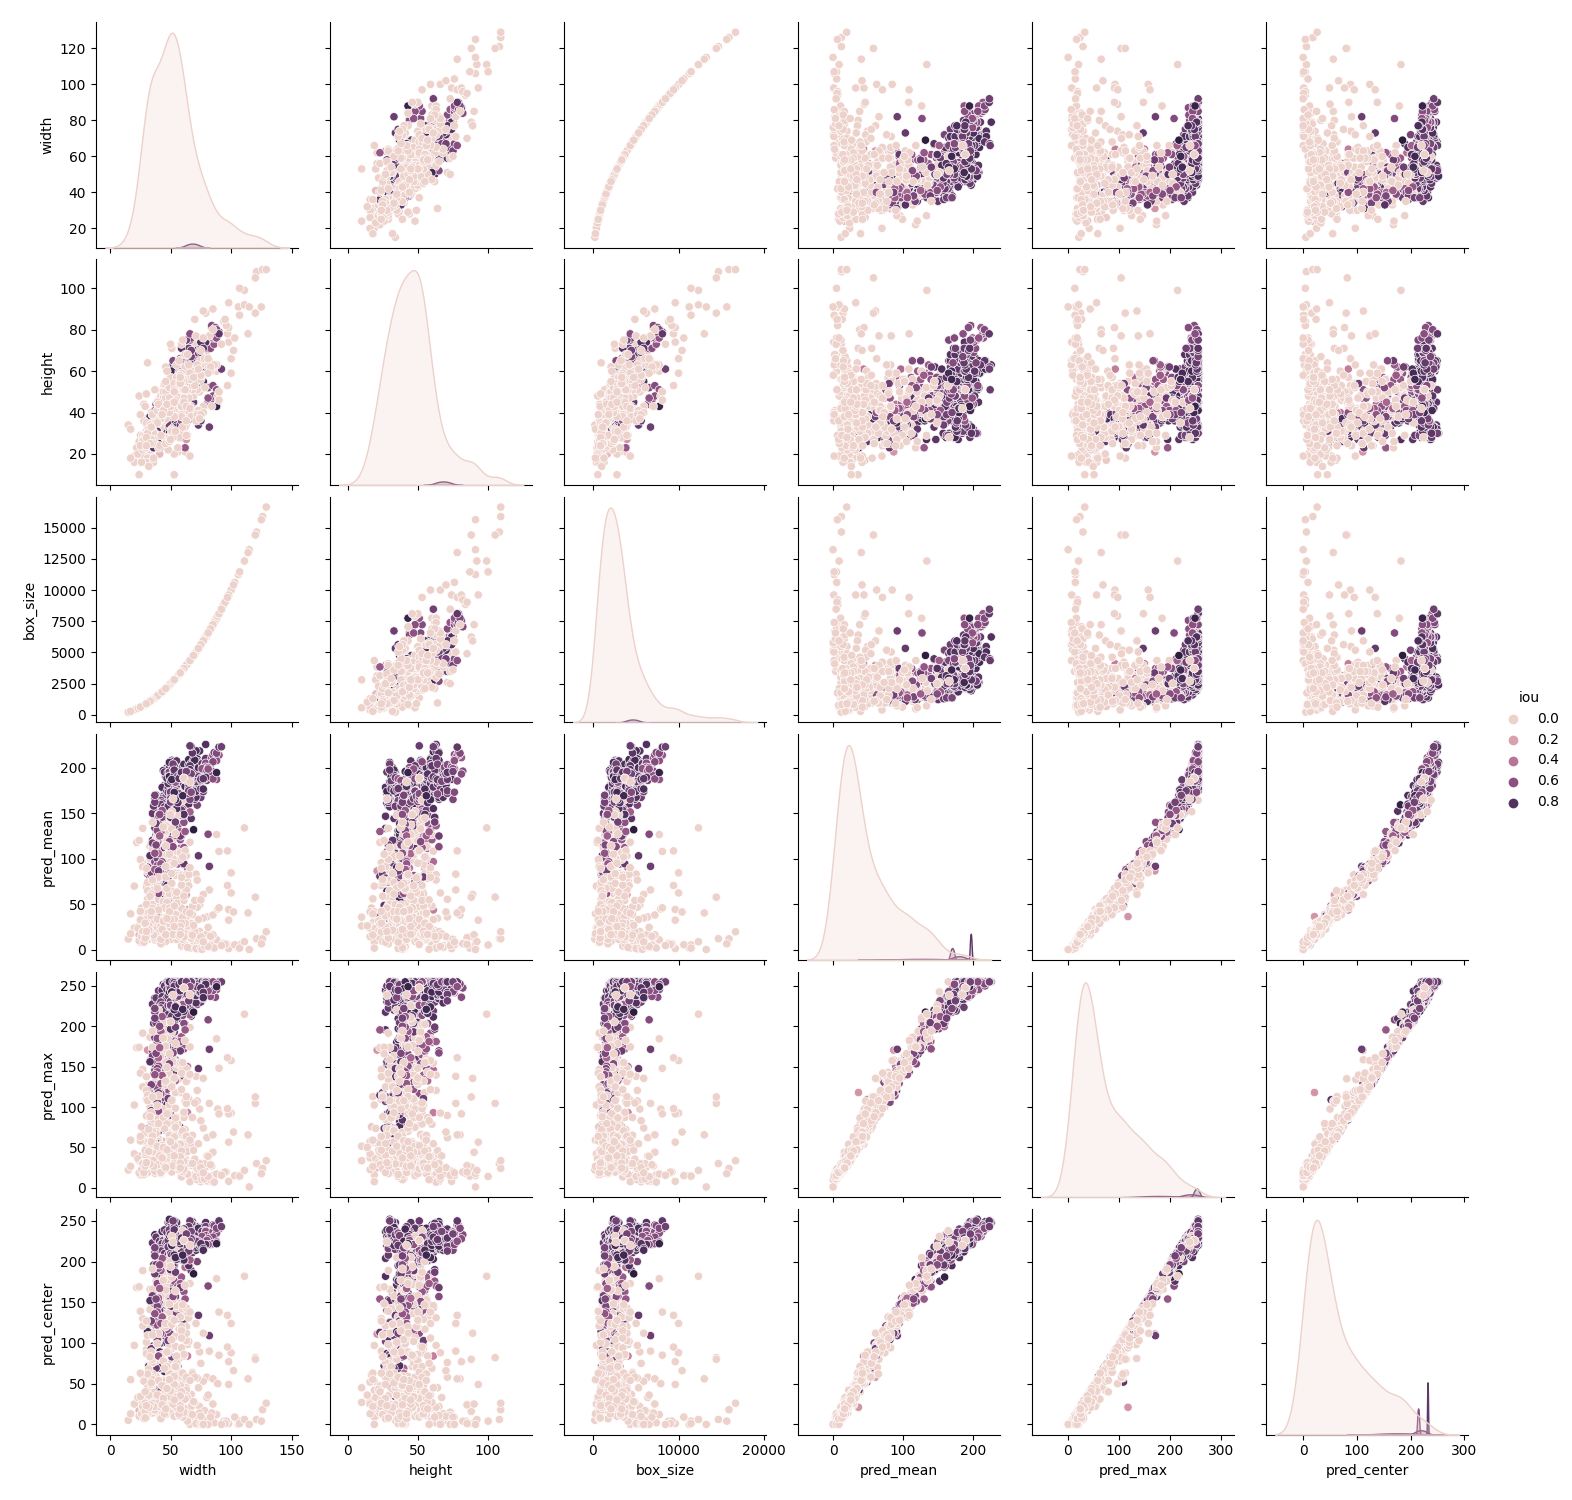

In [62]:
sns.pairplot(val_df[['width', 'height', 'box_size', 'pred_mean', 'pred_max', 'pred_center','iou']], hue='iou')
plt.show()

<IPython.core.display.Javascript object>


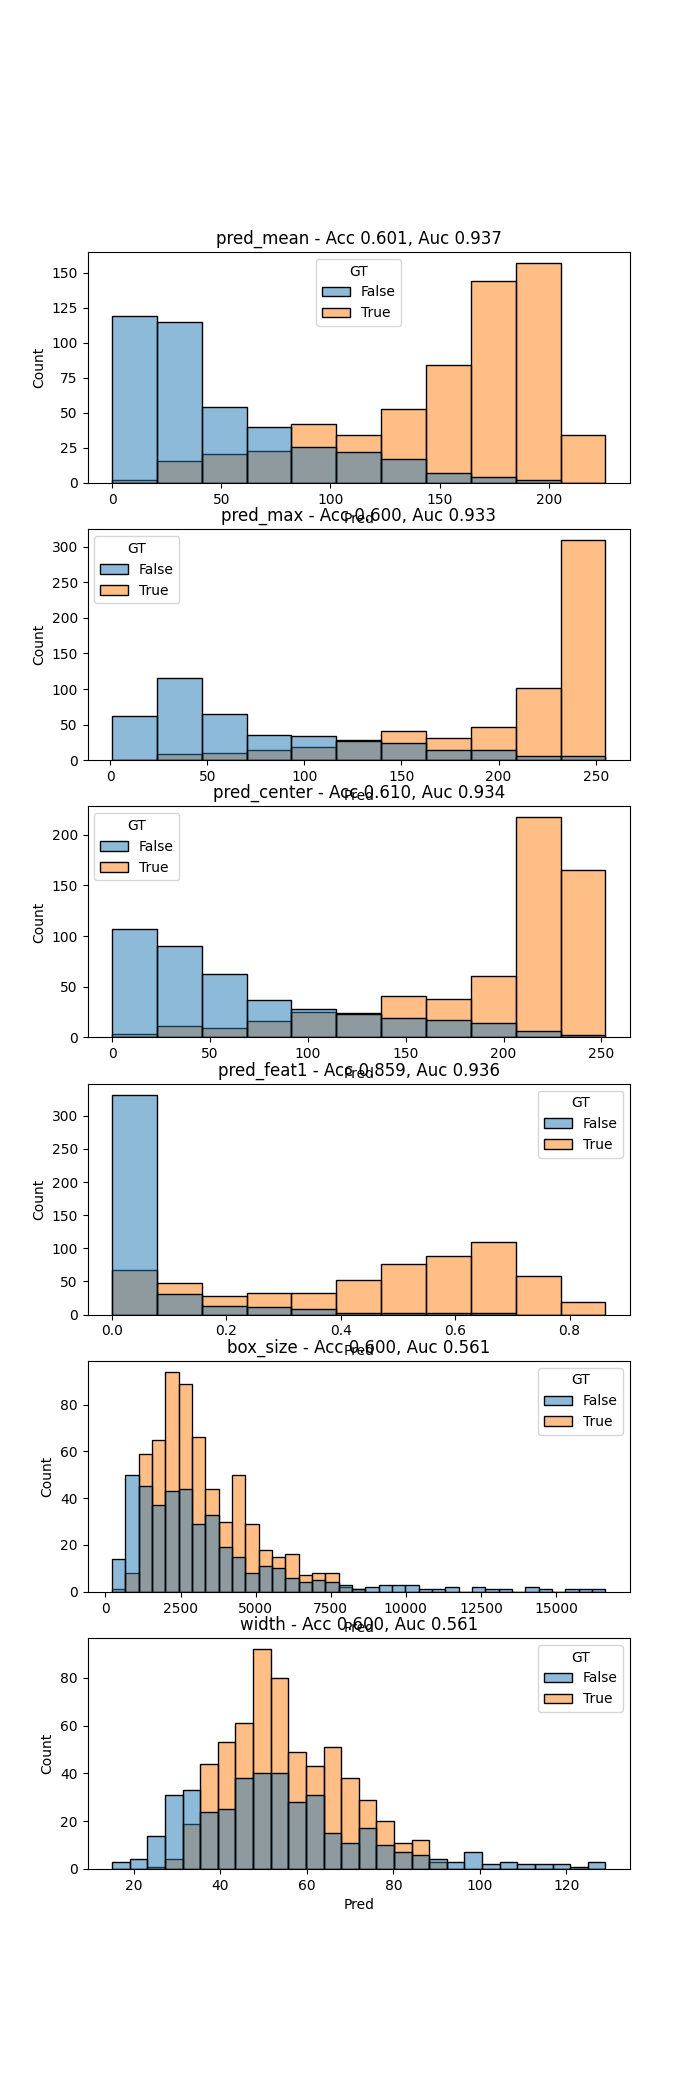

In [63]:
from sklearn.metrics import accuracy_score, roc_auc_score

gt_iou_th = 0.1
threshold = 0.1

plt.close('all')
f, ax = plt.subplots(6,1, figsize=(7,21))
for j, pred_val in enumerate(['pred_mean', 'pred_max', 'pred_center', 'pred_feat1', 'box_size', 'width']):
    preds = val_df[pred_val].values
    gts = val_df.iou.values
    
    acc = accuracy_score((np.array(gts) > gt_iou_th).flatten(), (np.array(preds) > threshold).flatten())
    auc = roc_auc_score((np.array(gts) > gt_iou_th).flatten().astype(np.float32), np.array(preds).flatten())
    
    df_plot = pd.DataFrame({'Pred': np.array(preds), 'GT': np.array(gts) > gt_iou_th})
    sns.histplot(x='Pred', hue='GT', data=df_plot, ax=ax[j])
    ax[j].set_title(f'{pred_val} - Acc {acc:.3f}, Auc {auc:.3f}')
plt.show()

In [64]:
def split_df_to_data(x_columns=[
    'width', 'height', 'box_size', 'pred_mean', 'pred_max', 'pred_center'
], target_col='iou', fold=4):
    n = len(val_df)
    fold_n = n // 5
    xs = val_df[x_columns].values
    ys = val_df[target_col].values
    
    train_xs = xs.copy()
    train_ys = ys.copy()
    val_xs = xs[fold*fold_n: (1+fold)*fold_n]
    val_ys = ys[fold*fold_n: (1+fold)*fold_n]
    train_xs = np.delete(train_xs, np.s_[fold*fold_n: (1+fold)*fold_n], 0)
    train_ys = np.delete(train_ys, np.s_[fold*fold_n: (1+fold)*fold_n], 0)
    return train_xs, train_ys, val_xs, val_ys

train_xs, train_ys, val_xs, val_ys = split_df_to_data()
train_xs.shape, train_ys.shape, val_xs.shape, val_ys.shape

((813, 6), (813,), (203, 6), (203,))

[-1.35450101e-05  4.09646016e-03]
[-1.04944370e-05  4.32140031e-03]
[-1.81176438e-05  4.26662649e-03]
[-2.29712205e-05  4.09180814e-03]
[-2.87356874e-05  4.11186744e-03]
Avg coefs [-1.87727997e-05  4.17763251e-03]


<IPython.core.display.Javascript object>


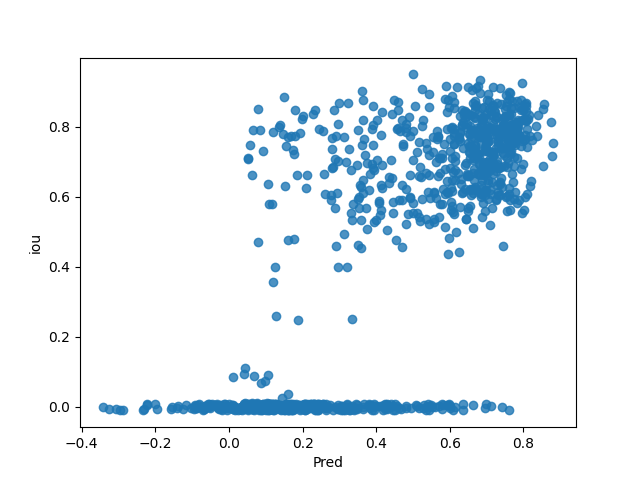

In [65]:
from sklearn import linear_model

oof_preds = []
oof_gts = []

x_columns = ['box_size', 'pred_mean']#, 'pred_center']#, 'pred_max']
coefs = []

for fold in range(5):
    train_xs, train_ys, val_xs, val_ys = split_df_to_data(x_columns=x_columns, fold=fold)
    reg = linear_model.LinearRegression()
    #reg = linear_model.BayesianRidge()
    reg.fit(train_xs, train_ys)
    val_pred = reg.predict(val_xs)
    oof_gts += list(val_ys)
    oof_preds += list(val_pred)
    print(reg.coef_)
    coefs.append(reg.coef_)

coefs = np.mean(np.array(coefs), 0)
print(f'Avg coefs {coefs}')

# sort in pred ascending order
oof_preds, oof_gts = zip(*sorted(zip(oof_preds, oof_gts)))
max_gts = []
mean_gts = []
perc_95_gts = []
data_percents = []
for i, (p, gt) in enumerate(zip(oof_preds, oof_gts)):
    max_gts.append(max(oof_gts[:i+1]))
    mean_gts.append(np.mean(oof_gts[:i+1]))
    perc_95_gts.append(np.percentile(oof_gts[:i+1], 95))
    data_percents.append(i / len(oof_preds))
    
df_plot = pd.DataFrame({'Pred': np.array(oof_preds), 'iou': np.array(oof_gts)})

sns.regplot(data=df_plot, x = 'Pred', y = 'iou', fit_reg = False, x_jitter = 0.01, y_jitter = 0.01)
plt.show()

7.2% under th:0.04 where GT-iou is under 0.1


<IPython.core.display.Javascript object>


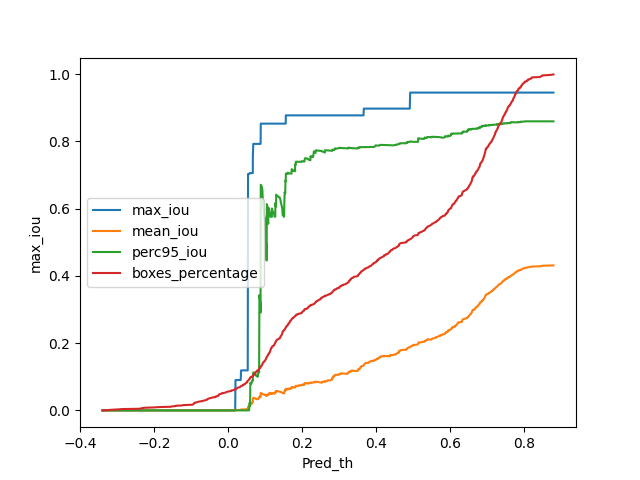

In [66]:
df_plot = pd.DataFrame({
    'Pred_th': np.array(oof_preds), 
    'max_iou': np.array(max_gts),
    'mean_iou': np.array(mean_gts),
    'perc95_iou': np.array(perc_95_gts),
    'boxes_percentage' : np.array(data_percents)
})

for p,m,perc in zip(oof_preds, max_gts, data_percents):
    if m > 0.1:
        print(f'{perc*100:.1f}% under th:{p:.2f} where GT-iou is under 0.1')
        break
        
sns.lineplot(data=df_plot, x = 'Pred_th', y = 'max_iou', label='max_iou')
sns.lineplot(data=df_plot, x = 'Pred_th', y = 'mean_iou', label='mean_iou')
sns.lineplot(data=df_plot, x = 'Pred_th', y = 'perc95_iou', label='perc95_iou')
sns.lineplot(data=df_plot, x = 'Pred_th', y = 'boxes_percentage', label='boxes_percentage')
plt.show()

## Test that loading the model still works

In [81]:
def get_dummy_dls(bs:int=32, size:int=128):
    dblock = DataBlock(
        blocks=(ImageBlock, ImageBlock),
        get_items=get_image_files,
        get_y = lambda x: x,
        splitter=RandomSplitter(),
        item_tfms=Resize(size),
        batch_tfms=[*aug_transforms(max_zoom=2.),
                    Normalize.from_stats(*imagenet_stats)])
    dls = dblock.dataloaders('../input/tensorflow-great-barrier-reef/train_images/video_0/', bs=bs, path='.')
    dls.c = 3 # For 1 channel image
    return dls

dummy_dls = get_dummy_dls(bs=32)

In [82]:
def create_inference_learner(dls):
    return unet_learner(
        dls, 
        arch=resnet34, 
        lr=0.001,
        wd=1e-3,
        loss_func = MSELossFlat(),              
        blur=True, 
        norm_type=NormType.Weight, 
        self_attention=True)

learn_inference = create_inference_learner(dummy_dls)

In [90]:
learn_inference.model.load_state_dict(torch.load(f'starfish_seg_resnet18_unet.pth'))

<All keys matched successfully>

In [91]:
gts = []
preds = []
for i in range(len(val_df)):
    img_fn = os.path.join(DIR_CROP, val_df['id'].values[i] + '.jpg')
    mask_fn = os.path.join(DIR_LABELS, val_df['id'].values[i] + '.jpg')
    img = cv2.cvtColor(cv2.imread(img_fn), cv2.COLOR_BGR2RGB)
    mask = cv2.imread(mask_fn)
    pred = learn_inference.predict(img)
    preds.append(is_pred_tp(pred[0].detach().numpy()[0]))
    gts.append(is_pred_tp(mask))

<IPython.core.display.Javascript object>


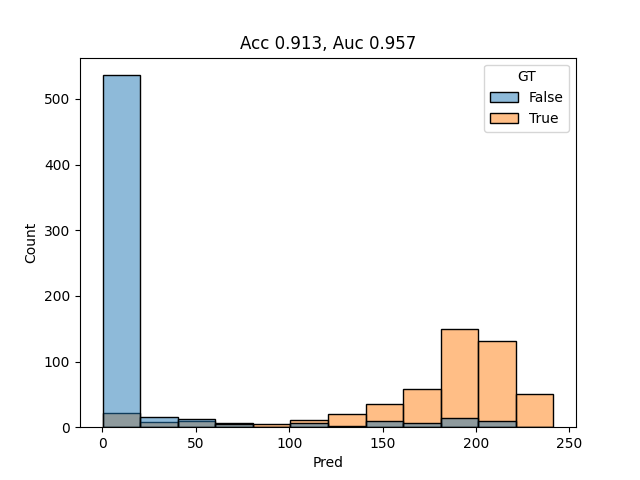

In [93]:
acc = accuracy_score((np.array(gts) > 100).flatten(), (np.array(preds) > 100).flatten())
auc = roc_auc_score((np.array(gts) > 100).flatten().astype(np.float32), np.array(preds).flatten())

df_plot = pd.DataFrame({'Pred': np.array(preds), 'GT': np.array(gts) > 100})
sns.histplot(x='Pred', hue='GT', data=df_plot)
plt.title(f'Acc {acc:.3f}, Auc {auc:.3f}')
plt.show()